# Домашнее задание

1. Получить точность 97.5% на валидации MNIST.
2. Реализовать морфинг автоэнкодером (без формальных критериев — просто получите красивую гифку).
3. Визуализировать MNIST автоэнкодером (обучить автоэнкодер с латентным пространством размерности 2 и вывести через scatter точки разного цвета).

# Часть 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    # Dataset в PyTorch -- это какой-то объект, который оборачивает сырые данные и делает с ними какой-нибудь препроцессинг
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    # DataLoader делает из датасета генератор, который возвращает данные, сгруппированные по батчам
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
model = nn.Sequential(
    nn.Linear(784, 392),
    nn.ReLU(),
    nn.Linear(392, 196),
    nn.ReLU(),
    nn.Linear(196, 10),
    nn.LogSoftmax(dim=1)
)

In [ ]:
def accuracy(model, val):
    total = 0
    correct = 0
    for X, y in val:
        X = X.view(-1, 784)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

train: 0.96575, val: 0.961
train: 0.9813666666666667, val: 0.9739
train: 0.9863666666666666, val: 0.9774
train: 0.9928833333333333, val: 0.9798
train: 0.9884666666666667, val: 0.9739
train: 0.9939333333333333, val: 0.9806
train: 0.9959333333333333, val: 0.9812
train: 0.9960666666666667, val: 0.9795
train: 0.9959833333333333, val: 0.9794
train: 0.9950166666666667, val: 0.9805


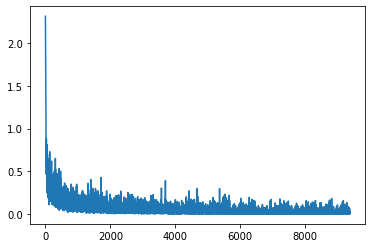

In [ ]:
train_losses = []
for epoch in range(10):
    for X, y in train:
        X = X.view(-1, 784)
        
        optimizer.zero_grad()
        
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()
    
    print(f'train: {accuracy(model, train)}, val: {accuracy(model, val)}')
        
plt.plot(train_losses)
plt.show()

# Часть 2

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(784, 392),
            nn.ReLU(),
            nn.Linear(392, 196),
            nn.ReLU(),
            nn.Linear(196, 2)
        )
        
        self.decode = nn.Sequential(
            nn.Linear(2, 196),
            nn.ReLU(),
            nn.Linear(196, 392),
            nn.ReLU(),
            nn.Linear(392, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

    def data_encode(self, x):
        return self.encode(x)

model = Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0512
epoch 1, loss 0.0418
epoch 2, loss 0.0398
epoch 3, loss 0.0388
epoch 4, loss 0.0380
epoch 5, loss 0.0373
epoch 6, loss 0.0368
epoch 7, loss 0.0364
epoch 8, loss 0.0360
epoch 9, loss 0.0357


In [ ]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [ ]:
def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    # перегоняем в латентное пространство все картинки на входе
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

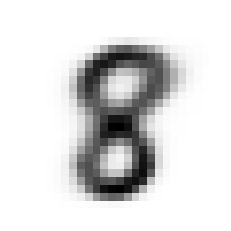

In [ ]:
morph(numpy.random.randint(0, len(train.dataset), 30), 20, 30)

# Часть 3

In [ ]:
dataset = get_loader(True, 1)

x, y, labels = [], [], []

for data, label in dataset:
    data = data.view(-1, 784)
    with torch.no_grad():
        encode = model.data_encode(data)
    x.append(encode[0][0])
    y.append(encode[0][1])
    labels.append(label.item())

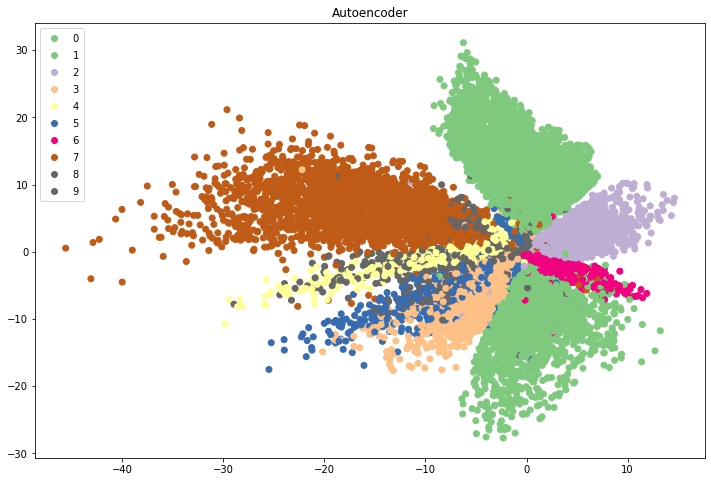

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('Autoencoder')
scatter = plt.scatter(x, y, c=labels, cmap='Accent')
plt.legend(*scatter.legend_elements());